<a href="https://colab.research.google.com/github/mnocerino23/MLB-Salary-Regressions/blob/main/StartingPitcher_Regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this Jupyter Notebook, I will build regression models to predict salary (in millions) for MLB position pitchers. I will experiment with different modeling techniques such as multivariate linear, lasso, ridge, and neural network regressions

In [333]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [334]:
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler

In [335]:
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso

In [336]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [337]:
#read in position player stats
starters_train = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/MLB/starters_train.csv')
starters_test = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/MLB/starters_test.csv')

# Final check for null values:

In [338]:
#no null values
starters_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 43 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     57 non-null     object 
 1   throws   57 non-null     object 
 2   age      57 non-null     int64  
 3   stints   57 non-null     int64  
 4   teamID   57 non-null     object 
 5   LG       57 non-null     object 
 6   POS1     57 non-null     object 
 7   W        57 non-null     int64  
 8   L        57 non-null     int64  
 9   CG       57 non-null     int64  
 10  ShO      57 non-null     int64  
 11  GP       57 non-null     int64  
 12  GS       57 non-null     int64  
 13  SV       57 non-null     int64  
 14  GF       57 non-null     int64  
 15  IPOuts   57 non-null     int64  
 16   IP      57 non-null     float64
 17   ERA     57 non-null     float64
 18  HA       57 non-null     int64  
 19  ER       57 non-null     int64  
 20  HRA      57 non-null     int64  
 21  BBA      57 non-nu

In [339]:
#test data also has no nulls so we are good
starters_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 43 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     15 non-null     object 
 1   throws   15 non-null     object 
 2   age      15 non-null     int64  
 3   stints   15 non-null     int64  
 4   teamID   15 non-null     object 
 5   LG       15 non-null     object 
 6   POS1     15 non-null     object 
 7   W        15 non-null     int64  
 8   L        15 non-null     int64  
 9   CG       15 non-null     int64  
 10  ShO      15 non-null     int64  
 11  GP       15 non-null     int64  
 12  GS       15 non-null     int64  
 13  SV       15 non-null     int64  
 14  GF       15 non-null     int64  
 15  IPOuts   15 non-null     int64  
 16   IP      15 non-null     float64
 17   ERA     15 non-null     float64
 18  HA       15 non-null     int64  
 19  ER       15 non-null     int64  
 20  HRA      15 non-null     int64  
 21  BBA      15 non-nu

In [340]:
starters_train.head(3)

,name,throws,age,stints,teamID,LG,POS1,W,L,CG,...,WHIP,WRIP,HRBIB,RAVG,FIP,DERA,STUFF,GURU,salary,WAR
0,Cl Kershaw,L,31,1,LAN,NL,Starter,16,5,0,...,1.04,1.80,0.09,3.18,3.84,3.75,115,72,31.000000,3.4
1,Jo Lyles,R,28,2,MIL,NL,Starter,12,8,0,...,1.32,2.16,0.10,4.60,4.63,4.41,66,39,0.694386,1.4
2,Iv Nova,R,32,1,CHA,AL,Starter,11,12,2,...,1.45,1.86,0.07,5.15,4.96,4.82,4,38,9.166668,2.0


In [341]:
starters_test.head(3)

,name,throws,age,stints,teamID,LG,POS1,W,L,CG,...,WHIP,WRIP,HRBIB,RAVG,FIP,DERA,STUFF,GURU,salary,WAR
0,Mi Mikolas,R,30,1,STL,NL,Starter,9,14,1,...,1.22,1.64,0.07,4.40,4.26,4.13,40,56,8.750,2.3
1,Ky Hendricks,R,29,1,CHN,NL,Starter,11,10,1,...,1.13,1.25,0.05,3.97,3.60,3.53,71,85,7.405,4.2
2,Ad Wainwright,R,37,1,STL,NL,Starter,14,10,0,...,1.43,1.65,0.06,4.35,4.34,4.12,45,54,10.000,2.2


In [342]:
#drop unncesary columns from both datasets

starters_train.drop(columns = ['name','stints', 'LG', 'teamID'], inplace = True)
starters_test.drop(columns = ['name','stints', 'LG', 'teamID'], inplace = True)
starters_test.head()

,throws,age,POS1,W,L,CG,ShO,GP,GS,SV,...,WHIP,WRIP,HRBIB,RAVG,FIP,DERA,STUFF,GURU,salary,WAR
0,R,30,Starter,9,14,1,1,32,32,0,...,1.22,1.64,0.07,4.40,4.26,4.13,40,56,8.750,2.3
1,R,29,Starter,11,10,1,1,30,30,0,...,1.13,1.25,0.05,3.97,3.60,3.53,71,85,7.405,4.2
2,R,37,Starter,14,10,0,0,31,31,0,...,1.43,1.65,0.06,4.35,4.34,4.12,45,54,10.000,2.2
3,R,28,Starter,20,5,0,0,33,33,0,...,0.89,1.59,0.10,2.80,2.63,2.53,408,248,13.500,7.4
4,L,30,Starter,13,9,0,0,32,31,0,...,1.39,1.44,0.06,5.26,3.78,3.75,65,70,10.500,3.2


# Reminding ourselves of the train and test data shapes (we performed an 80-20 split previously then normalized both independently)

In [343]:
print('Position Players Train:')
print('Train dataset dimensions: ', starters_train.shape, '\n')

print('Position Players Test:')
print('Test dataset dimensions: ', starters_test.shape, '\n')

Position Players Train:
Train dataset dimensions:  (57, 39) 

Position Players Test:
Test dataset dimensions:  (15, 39) 



# Add on feature for under rookie contract. If a player is 25 or under they are on their rookie contract else they are typically not

In [344]:
starters_train['Rookie contract'] = ''
starters_test['Rookie contract'] = ''

for index, row in starters_train.iterrows():
  if starters_train.at[index,'age'] <= 25:
    starters_train.at[index,'Rookie contract'] = 1
  else:
    starters_train.at[index,'Rookie contract'] = 0

for index, row in starters_test.iterrows():
  if starters_test.at[index,'age'] <= 25:
    starters_test.at[index,'Rookie contract'] = 1
  else:
    starters_test.at[index,'Rookie contract'] = 0

# One-hot encode position:

In [345]:
dummy_position = pd.get_dummies(starters_train['POS1'])
dummy_throws = pd.get_dummies(starters_train['throws'], prefix = 'throws')
items = [dummy_position, dummy_throws]
for item in items:
  starters_train = pd.merge(left = starters_train, right = item, left_index = True, right_index = True)

starters_train.drop(columns = ['POS1', 'throws'], axis = 1, inplace = True)

In [346]:
dummy_pos = pd.get_dummies(starters_test['POS1'])
dummy_throw = pd.get_dummies(starters_test['throws'], prefix = 'throws')
items = [dummy_pos, dummy_throw]

for item in items:
  starters_test = pd.merge(left = starters_test, right = item, left_index = True, right_index = True)

starters_test.drop(columns = ['POS1', 'throws'], axis = 1, inplace = True)

In [347]:
#display both  dataframes to ensure we have done this correctly
starters_train.head(3)

,age,W,L,CG,ShO,GP,GS,SV,GF,IPOuts,...,FIP,DERA,STUFF,GURU,salary,WAR,Rookie contract,Starter,throws_L,throws_R
0,31,16,5,0,0,29,28,0,0,535,...,3.84,3.75,115,72,31.000000,3.4,0,1,1,0
1,28,12,8,0,0,28,28,0,0,423,...,4.63,4.41,66,39,0.694386,1.4,0,1,0,1
2,32,11,12,2,0,34,34,0,0,561,...,4.96,4.82,4,38,9.166668,2.0,0,1,0,1


In [348]:
starters_test.head(3)

,age,W,L,CG,ShO,GP,GS,SV,GF,IPOuts,...,FIP,DERA,STUFF,GURU,salary,WAR,Rookie contract,Starter,throws_L,throws_R
0,30,9,14,1,1,32,32,0,0,552,...,4.26,4.13,40,56,8.750,2.3,0,1,0,1
1,29,11,10,1,1,30,30,0,0,531,...,3.60,3.53,71,85,7.405,4.2,0,1,0,1
2,37,14,10,0,0,31,31,0,0,515,...,4.34,4.12,45,54,10.000,2.2,0,1,0,1


In [349]:
#pitchers train has two invalid entries which are causing issues. We will drop both rows
starters_train.head(10)
#print(starters_train.at[8, ' HR9 '])

#starters_train = starters_train.drop(8)
#starters_train = starters_train.reset_index(drop = True)

#print(starters_train.at[31, ' GURU '])
#starters_train = starters_train.drop(31)
#starters_train = starters_train.reset_index(drop = True)

,age,W,L,CG,ShO,GP,GS,SV,GF,IPOuts,...,FIP,DERA,STUFF,GURU,salary,WAR,Rookie contract,Starter,throws_L,throws_R
0,31,16,5,0,0,29,28,0,0,535,...,3.84,3.75,115,72,31.000000,3.4,0,1,1,0
1,28,12,8,0,0,28,28,0,0,423,...,4.63,4.41,66,39,0.694386,1.4,0,1,0,1
2,32,11,12,2,0,34,34,0,0,561,...,4.96,4.82,4,38,9.166668,2.0,0,1,0,1
3,25,14,8,1,0,32,32,0,0,601,...,3.84,3.74,89,78,0.620000,4.3,1,1,0,1
4,27,12,8,0,0,33,33,0,0,523,...,4.27,4.04,170,57,6.050000,1.9,0,1,1,0
5,35,11,8,0,0,30,30,0,0,498,...,4.43,4.16,29,51,6.000000,2.2,0,1,0,1
6,34,11,7,0,0,27,27,0,0,517,...,2.43,2.38,359,272,37.505562,6.5,0,1,0,1
7,32,6,8,0,0,31,31,0,0,536,...,4.16,3.95,176,62,20.000000,2.3,0,1,0,1
8,35,13,10,0,0,31,31,0,0,515,...,4.24,4.11,67,54,27.500000,3.2,0,1,1,0
9,26,6,9,0,0,32,29,0,0,463,...,4.57,4.41,52,41,0.555000,2.0,0,1,0,1


In [350]:
starters_train.head(10)

,age,W,L,CG,ShO,GP,GS,SV,GF,IPOuts,...,FIP,DERA,STUFF,GURU,salary,WAR,Rookie contract,Starter,throws_L,throws_R
0,31,16,5,0,0,29,28,0,0,535,...,3.84,3.75,115,72,31.000000,3.4,0,1,1,0
1,28,12,8,0,0,28,28,0,0,423,...,4.63,4.41,66,39,0.694386,1.4,0,1,0,1
2,32,11,12,2,0,34,34,0,0,561,...,4.96,4.82,4,38,9.166668,2.0,0,1,0,1
3,25,14,8,1,0,32,32,0,0,601,...,3.84,3.74,89,78,0.620000,4.3,1,1,0,1
4,27,12,8,0,0,33,33,0,0,523,...,4.27,4.04,170,57,6.050000,1.9,0,1,1,0
5,35,11,8,0,0,30,30,0,0,498,...,4.43,4.16,29,51,6.000000,2.2,0,1,0,1
6,34,11,7,0,0,27,27,0,0,517,...,2.43,2.38,359,272,37.505562,6.5,0,1,0,1
7,32,6,8,0,0,31,31,0,0,536,...,4.16,3.95,176,62,20.000000,2.3,0,1,0,1
8,35,13,10,0,0,31,31,0,0,515,...,4.24,4.11,67,54,27.500000,3.2,0,1,1,0
9,26,6,9,0,0,32,29,0,0,463,...,4.57,4.41,52,41,0.555000,2.0,0,1,0,1


# Normalize input features using min-max normalization

In [351]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [352]:
train_target = starters_train['salary']

train_features = starters_train.drop(columns = ['salary'])
col = train_features.columns
train_features = scaler.fit_transform(train_features)
train_features = pd.DataFrame(data=train_features, columns=col)

In [353]:
test_target = starters_test['salary']

test_features = starters_test.drop(columns = ['salary'])
test_features = scaler.fit_transform(test_features)
test_features = pd.DataFrame(data=test_features, columns=col)

# Feature Selection

Vary the number of features we select to find optimal amount. I found that k = 12 features produces the best model with MAE of 3.49 million

In [354]:
#top_features_ordered = []

In [355]:
#best_features = SelectKBest(f_regression, k=12)
#k_best_data = best_features.fit_transform(train_features, train_target)
#mask = best_features.get_support()
#new_features = train_features.columns[mask]
#for item in new_features:
  #if item not in top_features_ordered:
   # top_features_ordered.append(item)

In [356]:
#count = 1
#for item in top_features_ordered:
  #print(count, '. ', item)
  #count += 1

In [357]:
train_selected_X = train_features[['age', ' ERA ', 'W', ' GURU ', 'WAR', 'Rookie contract', ' WHIP ']]
train_y = train_target

test_selected_X = test_features[['age', ' ERA ', 'W', ' GURU ', 'WAR', 'Rookie contract', ' WHIP ']]
test_y = test_target

In [358]:
print('Train Features:')
print('train_selected_X dimensions: ', train_selected_X.shape)
print('train_y dimensions:', train_y.shape, '\n')

print('Test Features:')
print('test_data_X dimensions: ', test_selected_X.shape)
print('test_data_y dimensions:', test_y.shape, '\n')

Train Features:
train_selected_X dimensions:  (57, 7)
train_y dimensions: (57,) 

Test Features:
test_data_X dimensions:  (15, 7)
test_data_y dimensions: (15,) 



# Multivariate Linear Regression

In [359]:
multivariate_regression = linear_model.LinearRegression()
multivariate_regression.fit(train_selected_X, train_y)

LinearRegression()

# Beta values (coefficients) and intercept for our multivariate linear regression:

In [360]:
multivariate_regression.coef_

array([ 20.18645145,   4.70581579,  -2.1650946 ,  24.59667986,
       -11.68588268,   0.5148058 ,  -3.29291678])

In [361]:
multivariate_regression.intercept_

-3.4488044635500197

In [362]:
y_pred = multivariate_regression.predict(test_selected_X)

In [363]:
print('Mean Squared Error: ', mean_squared_error(test_y, y_pred), '\n')
print('Mean Absolute Error: ', mean_absolute_error(test_y, y_pred), '\n')
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test_y, y_pred)))

Mean Squared Error:  22.223808183353025 

Mean Absolute Error:  4.073990858078747 

Root Mean Squared Error:  4.714213421489636


# Ridge Regression

In [364]:
ridge_regression = Ridge(alpha = 6.5)
ridge_regression.fit(train_selected_X, train_y)

Ridge(alpha=6.5)

In [365]:
ridge_regression.coef_

array([ 5.94298572, -0.78136947, -0.09348128,  2.47533141,  0.89397095,
       -3.17366131, -1.24578042])

In [366]:
ridge_regression.intercept_

4.676353899628014

In [367]:
y_predicted = ridge_regression.predict(test_selected_X)

In [368]:
print('Mean Squared Error: ', mean_squared_error(test_y, y_predicted), '\n')
print('Mean Absolute Error: ', mean_absolute_error(test_y, y_predicted), '\n')
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test_y, y_predicted)))

Mean Squared Error:  11.294660499245243 

Mean Absolute Error:  2.4876859362804793 

Root Mean Squared Error:  3.3607529661141777


# Lasso Regression

In [369]:
lasso_regression = Lasso(alpha = 0.3)
lasso_regression.fit(train_selected_X, train_y)

Lasso(alpha=0.3)

In [370]:
lasso_regression.coef_

array([15.43196214, -0.        , -0.        ,  2.78174677,  0.        ,
       -0.        , -0.        ])

In [371]:
lasso_regression.intercept_

-1.5923591278278417

In [372]:
y_predicted_lasso = lasso_regression.predict(test_selected_X)

In [373]:
print('Mean Squared Error: ', mean_squared_error(test_y, y_predicted_lasso), '\n')
print('Mean Absolute Error: ', mean_absolute_error(test_y, y_predicted_lasso), '\n')
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test_y, y_predicted_lasso)))

Mean Squared Error:  13.764996770460844 

Mean Absolute Error:  3.0655383508913596 

Root Mean Squared Error:  3.7101208565841683


# Regression with Deep Learning

In [374]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

In [375]:
tf.random.set_seed(5)

network1 = tf.keras.models.Sequential()
network1.add(tf.keras.Input(shape=(40,)))
network1.add(tf.keras.layers.Dense(15, activation='relu'))
network1.add(tf.keras.layers.Dense(15, activation='relu'))
network1.add(tf.keras.layers.Dense(1))

network1.compile(
   loss=tf.keras.losses.MeanAbsoluteError(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics='mean_absolute_error')

history1 = network1.fit(train_features, train_target, epochs=140,validation_data=(test_features,test_target))

Epoch 1/140
2/2 [==============================] - 1s 211ms/step - loss: 6.9554 - mean_absolute_error: 6.9554 - val_loss: 6.9819 - val_mean_absolute_error: 6.9819
Epoch 2/140
2/2 [==============================] - 0s 32ms/step - loss: 6.8847 - mean_absolute_error: 6.8847 - val_loss: 6.9129 - val_mean_absolute_error: 6.9129
Epoch 3/140
2/2 [==============================] - 0s 41ms/step - loss: 6.8057 - mean_absolute_error: 6.8057 - val_loss: 6.8364 - val_mean_absolute_error: 6.8364
Epoch 4/140
2/2 [==============================] - 0s 29ms/step - loss: 6.7225 - mean_absolute_error: 6.7225 - val_loss: 6.7630 - val_mean_absolute_error: 6.7630
Epoch 5/140
2/2 [==============================] - 0s 37ms/step - loss: 6.6489 - mean_absolute_error: 6.6489 - val_loss: 6.7052 - val_mean_absolute_error: 6.7052
Epoch 6/140
2/2 [==============================] - 0s 41ms/step - loss: 6.5727 - mean_absolute_error: 6.5727 - val_loss: 6.6566 - val_mean_absolute_error: 6.6566
Epoch 7/140
2/2 [==========

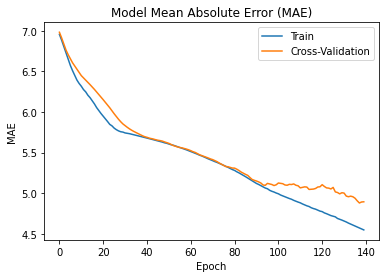

In [376]:
from matplotlib import pyplot as plt
plt.plot(history1.history['mean_absolute_error'])
plt.plot(history1.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()

In [377]:
tf.random.set_seed(5)

network2 = tf.keras.models.Sequential()
network2.add(tf.keras.Input(shape=(40,)))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(1))

network2.compile(
   loss=tf.keras.losses.MeanAbsoluteError(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics='mean_absolute_error')

history2 = network2.fit(train_features, train_target, epochs=80,validation_data=(test_features,test_target))

Epoch 1/80
2/2 [==============================] - 1s 208ms/step - loss: 7.1142 - mean_absolute_error: 7.1142 - val_loss: 7.1916 - val_mean_absolute_error: 7.1916
Epoch 2/80
2/2 [==============================] - 0s 32ms/step - loss: 7.0731 - mean_absolute_error: 7.0731 - val_loss: 7.1555 - val_mean_absolute_error: 7.1555
Epoch 3/80
2/2 [==============================] - 0s 34ms/step - loss: 7.0353 - mean_absolute_error: 7.0353 - val_loss: 7.1164 - val_mean_absolute_error: 7.1164
Epoch 4/80
2/2 [==============================] - 0s 37ms/step - loss: 6.9934 - mean_absolute_error: 6.9934 - val_loss: 7.0733 - val_mean_absolute_error: 7.0733
Epoch 5/80
2/2 [==============================] - 0s 41ms/step - loss: 6.9490 - mean_absolute_error: 6.9490 - val_loss: 7.0244 - val_mean_absolute_error: 7.0244
Epoch 6/80
2/2 [==============================] - 0s 43ms/step - loss: 6.8979 - mean_absolute_error: 6.8979 - val_loss: 6.9703 - val_mean_absolute_error: 6.9703
Epoch 7/80
2/2 [=================

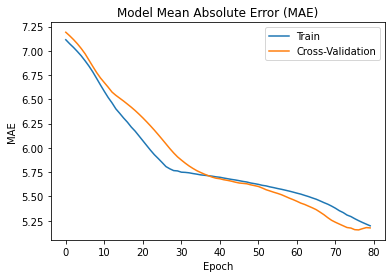

In [378]:
from matplotlib import pyplot as plt
plt.plot(history2.history['mean_absolute_error'])
plt.plot(history2.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()

In [379]:
tf.random.set_seed(5)

network3 = tf.keras.models.Sequential()
network3.add(tf.keras.Input(shape=(7,)))
network3.add(tf.keras.layers.Dense(20, activation='relu'))
network3.add(tf.keras.layers.Dense(20, activation='relu'))
network3.add(tf.keras.layers.Dense(20, activation='relu'))
network3.add(tf.keras.layers.Dense(20, activation='relu'))
network3.add(tf.keras.layers.Dense(1))

network3.compile(
   loss=tf.keras.losses.MeanAbsoluteError(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics='mean_absolute_error')

history3 = network3.fit(train_selected_X, train_target, epochs=120,validation_data=(test_selected_X,test_target))

Epoch 1/120
2/2 [==============================] - 1s 166ms/step - loss: 7.1084 - mean_absolute_error: 7.1084 - val_loss: 7.2039 - val_mean_absolute_error: 7.2039
Epoch 2/120
2/2 [==============================] - 0s 29ms/step - loss: 7.0803 - mean_absolute_error: 7.0803 - val_loss: 7.1803 - val_mean_absolute_error: 7.1803
Epoch 3/120
2/2 [==============================] - 0s 24ms/step - loss: 7.0542 - mean_absolute_error: 7.0542 - val_loss: 7.1571 - val_mean_absolute_error: 7.1571
Epoch 4/120
2/2 [==============================] - 0s 25ms/step - loss: 7.0286 - mean_absolute_error: 7.0286 - val_loss: 7.1326 - val_mean_absolute_error: 7.1326
Epoch 5/120
2/2 [==============================] - 0s 30ms/step - loss: 7.0029 - mean_absolute_error: 7.0029 - val_loss: 7.1068 - val_mean_absolute_error: 7.1068
Epoch 6/120
2/2 [==============================] - 0s 29ms/step - loss: 6.9760 - mean_absolute_error: 6.9760 - val_loss: 7.0791 - val_mean_absolute_error: 7.0791
Epoch 7/120
2/2 [==========

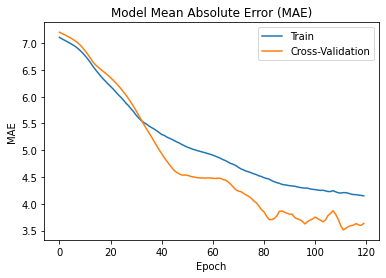

In [380]:
from matplotlib import pyplot as plt
plt.plot(history3.history['mean_absolute_error'])
plt.plot(history3.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()